In [131]:
import IPython
import IPython.display
import pandas as pd
import numpy as np
import datetime as dt
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
from workalendar.europe import Belgium
import sys
np.set_printoptions(threshold=sys.maxsize)
mpl.rcParams['figure.figsize'] = (15, 10)

In [115]:
user_input = './Consumption_15min.csv'
holidata = pd.read_csv(user_input, index_col=0)
holidata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177792 entries, 2014-12-06 00:00:00 to 2019-12-31 23:45:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Valeur  177792 non-null  float64
dtypes: float64(1)
memory usage: 2.7+ MB


In [132]:
def preprocess(dataframe):
    cal = Belgium()
    years = list(range(2014, 2025))
    holidays = []
    for year in years:
        holidays.extend(cal.holidays(year))
    dataframe.index = pd.to_datetime(dataframe.index)
    dataframe = dataframe.sort_index()
    dataframe['working day'] = dataframe.index.map(cal.is_working_day)
    dataframe['working day'] = dataframe['working day'].astype('float64')
    dataframe['working day next'] = dataframe['working day'].shift(periods=-96)
    dataframe['working day after next'] = dataframe['working day'].shift(periods=-192)
    #dataframe['working day'] = dataframe['working day'].fill
    dataframe['hour of day'] = dataframe.index.hour
    dataframe['day of week'] = dataframe.index.dayofweek
    dataframe['day of year'] = dataframe.index.dayofyear
    dataframe['minutes'] = dataframe.index.minute
    # we encode cynical data into two dimensions using a sine and cosine transformations
    def encode(data, col, max_val):
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
        return data
    dataframe = encode(dataframe, 'hour of day', 23)
    dataframe = encode(dataframe, 'day of week', 6)
    dataframe = encode(dataframe, 'day of year', 365)
    dataframe = encode(dataframe, 'minutes', 60)
    dataframe = dataframe.drop(['hour of day', 'day of week', 'day of year', 'minutes'], axis=1)
    dataframe = dataframe.fillna(method='ffill')
    return dataframe    

In [133]:
df = preprocess(holidata)
df.head(20)

,Valeur,working day,working day next,working day after next,hour of day_sin,hour of day_cos,day of week_sin,day of week_cos,day of year_sin,day of year_cos,minutes_sin,minutes_cos
Datetime,,,,,,,,,,,,
2014-12-06 00:00:00,7.14,0.0,0.0,1.0,0.000000,1.000000,-0.866025,0.5,-0.417194,0.908818,0.000000e+00,1.000000e+00
2014-12-06 00:15:00,7.56,0.0,0.0,1.0,0.000000,1.000000,-0.866025,0.5,-0.417194,0.908818,1.000000e+00,2.832769e-16
2014-12-06 00:30:00,6.72,0.0,0.0,1.0,0.000000,1.000000,-0.866025,0.5,-0.417194,0.908818,5.665539e-16,-1.000000e+00
2014-12-06 00:45:00,6.93,0.0,0.0,1.0,0.000000,1.000000,-0.866025,0.5,-0.417194,0.908818,-1.000000e+00,-1.836970e-16
2014-12-06 01:00:00,7.14,0.0,0.0,1.0,0.269797,0.962917,-0.866025,0.5,-0.417194,0.908818,0.000000e+00,1.000000e+00
2014-12-06 01:15:00,6.93,0.0,0.0,1.0,0.269797,0.962917,-0.866025,0.5,-0.417194,0.908818,1.000000e+00,2.832769e-16
2014-12-06 01:30:00,7.14,0.0,0.0,1.0,0.269797,0.962917,-0.866025,0.5,-0.417194,0.908818,5.665539e-16,-1.000000e+00
2014-12-06 01:45:00,6.93,0.0,0.0,1.0,0.269797,0.962917,-0.866025,0.5,-0.417194,0.908818,-1.000000e+00,-1.836970e-16
2014-12-06 02:00:00,6.93,0.0,0.0,1.0,0.519584,0.854419,-0.866025,0.5,-0.417194,0.908818,0.000000e+00,1.000000e+00


In [118]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [119]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

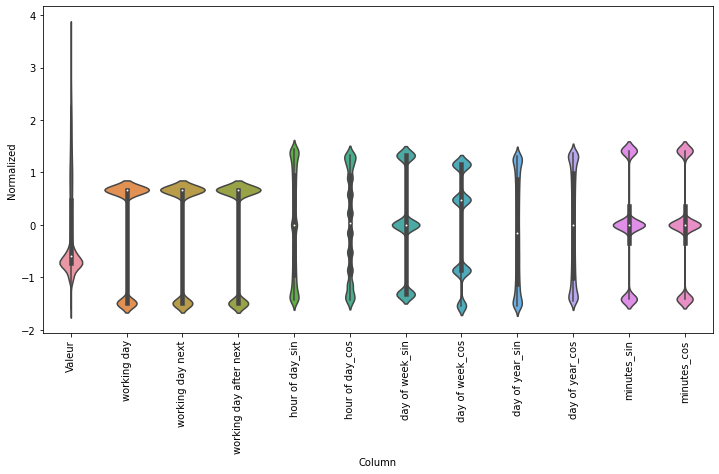

In [120]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


In [121]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, plot_col='Valeur', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(15, 10))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.plot(self.label_indices, labels[n, :, label_col_index], marker='.', label='Labels', c='#2ca02c')
            if model is not None:
                predictions = model(inputs)
                plt.plot(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', label='Predictions',
                          c='#ff7f0e')

            if n == 0:
                plt.legend()
        plt.xlabel('Time [15-min steps]')


In [122]:
multi_window = WindowGenerator(input_width=672, label_width=192, shift=192,
                     label_columns=['Valeur'], train_df=train_df, val_df=val_df, test_df=test_df)
multi_window

Total window size: 864
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [123]:
# Each element is an (inputs, label) pair
multi_window.train.element_spec

(TensorSpec(shape=(None, 672, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 192, 1), dtype=tf.float32, name=None))

In [124]:
for example_inputs, example_labels in multi_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 672, 12)
Labels shape (batch, time, features): (32, 192, 1)


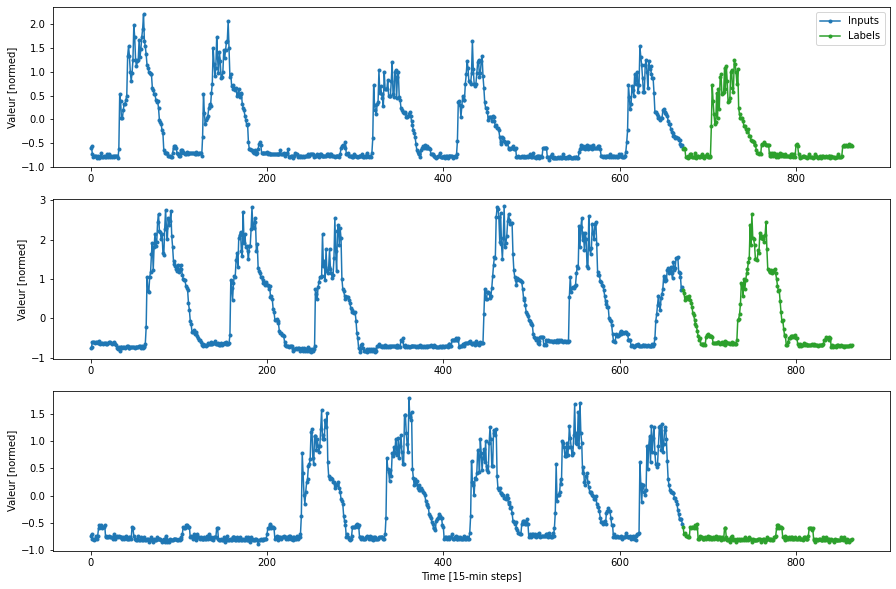

In [125]:
multi_window.plot()

In [126]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [130]:
OUT_STEPS = 192
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/20
3863/3863 [==============================] - 1503s 389ms/step - loss: 0.3505 - mean_absolute_error: 0.3882 - root_mean_squared_error: 0.5920 - mean_absolute_percentage_error: 70.2782 - val_loss: 0.2812 - val_mean_absolute_error: 0.3647 - val_root_mean_squared_error: 0.5303 - val_mean_absolute_percentage_error: 161.3845
Epoch 2/20
3863/3863 [==============================] - 1349s 349ms/step - loss: 0.2971 - mean_absolute_error: 0.3423 - root_mean_squared_error: 0.5450 - mean_absolute_percentage_error: 65.6636 - val_loss: 0.2755 - val_mean_absolute_error: 0.3590 - val_root_mean_squared_error: 0.5249 - val_mean_absolute_percentage_error: 147.5046
Epoch 3/20
2914/3863 [=====================>........] - ETA: 5:05 - loss: 0.2760 - mean_absolute_error: 0.3275 - root_mean_squared_error: 0.5254 - mean_absolute_percentage_error: 64.3146

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3863/3863 [==============================] - 1400s 362ms/step - loss: 0.2657 - mean_absolute_error: 0.3193 - root_mean_squared_error: 0.5155 - mean_absolute_percentage_error: 63.2782 - val_loss: 0.2863 - val_mean_absolute_error: 0.3621 - val_root_mean_squared_error: 0.5350 - val_mean_absolute_percentage_error: 155.7319
Epoch 6/20
3863/3863 [==============================] - 1428s 370ms/step - loss: 0.2679 - mean_absolute_error: 0.3223 - root_mean_squared_error: 0.5176 - mean_absolute_percentage_error: 63.6765 - val_loss: 0.2989 - val_mean_absolute_error: 0.3688 - val_root_mean_squared_error: 0.5467 - val_mean_absolute_percentage_error: 158.5225


1085/1085 [==============================] - 98s 90ms/step - loss: 0.2989 - mean_absolute_error: 0.3688 - root_mean_squared_error: 0.5467 - mean_absolute_percentage_error: 158.5225


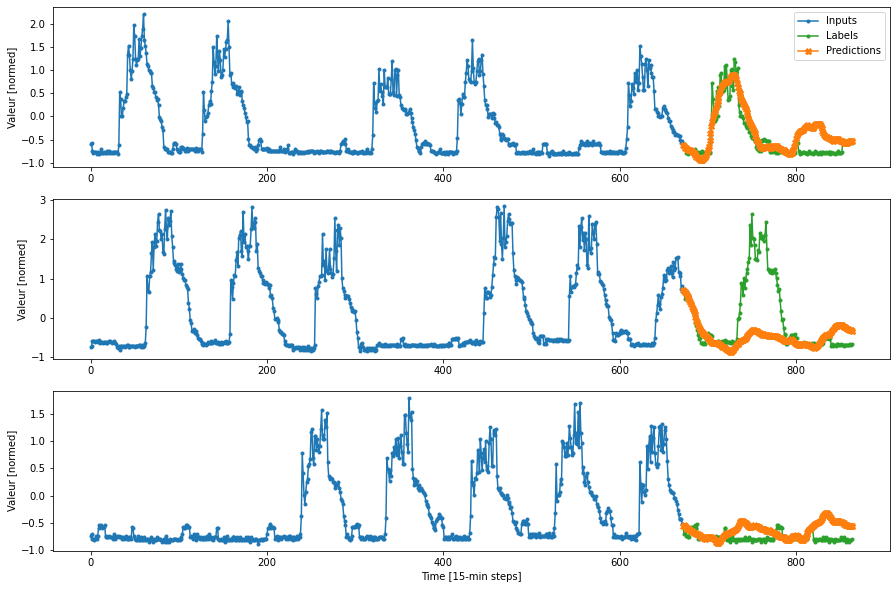

In [136]:
multi_val_performance = {}
multi_performance = {}

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [140]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)


ValueError: in user code:

    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1176 test_step
        self.compiled_loss(
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1195 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:10398 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3477 _create_op_internal
        ret = Operation(
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 672 and 192 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](IteratorGetNext, IteratorGetNext:1)' with input shapes: [?,672,12], [?,192,1].


In [137]:
print(multi_val_performance['LSTM'])
print(multi_performance['LSTM'])
print(multi_lstm_model.metrics_names)

[0.29892927408218384, 0.3688053488731384, 0.5467444658279419, 158.52247619628906]
[0.42885833978652954, 0.45858991146087646, 0.6548728346824646, 219.6578369140625]
['loss', 'mean_absolute_error', 'root_mean_squared_error', 'mean_absolute_percentage_error']


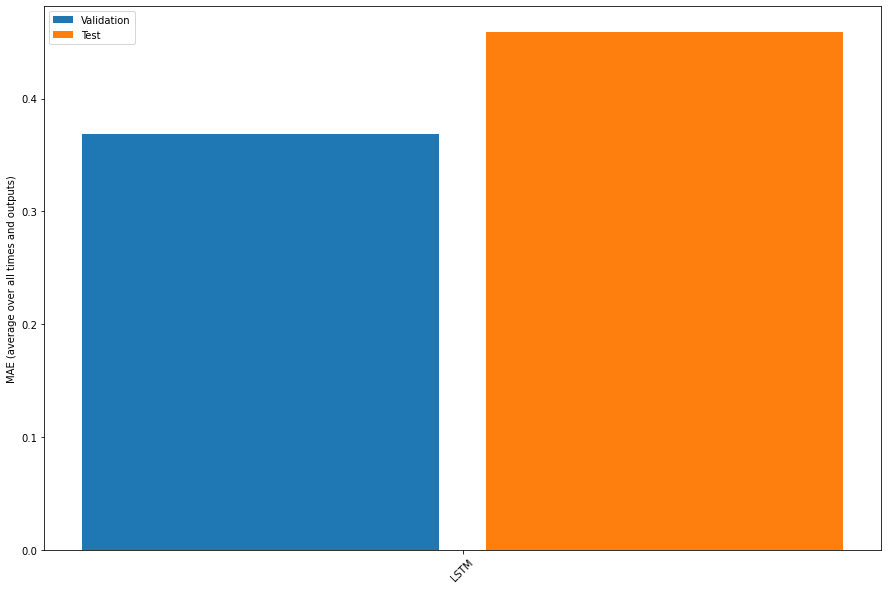

In [139]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()